[INFO] Using activation directory: activations
[INFO] Loaded 5 prompts × 36 layers.
[INFO] Example vector shape: (2048,)
   Layer  Prompt_i  Prompt_j  Cosine_Overlap
0      0         1         2        0.894531
1      0         1         3        0.902392
2      0         1         4        0.887207
3      0         1         5        0.884334
4      0         2         3        0.894095


/home/rameyjm7/workspace/TML/lpu/llm-preference-unlearning/lpu-env/lib/python3.10/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: invalid value encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


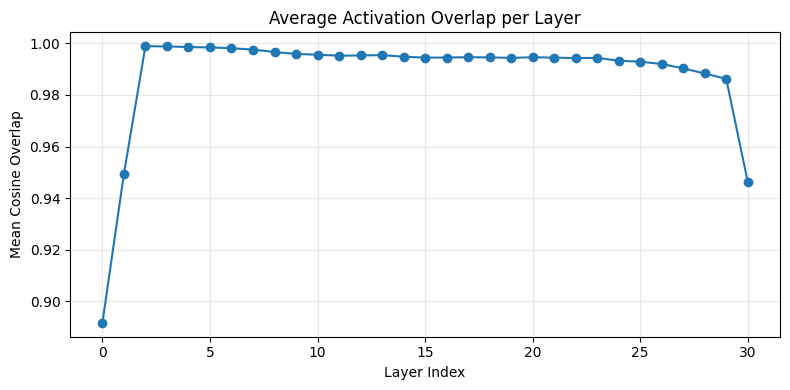

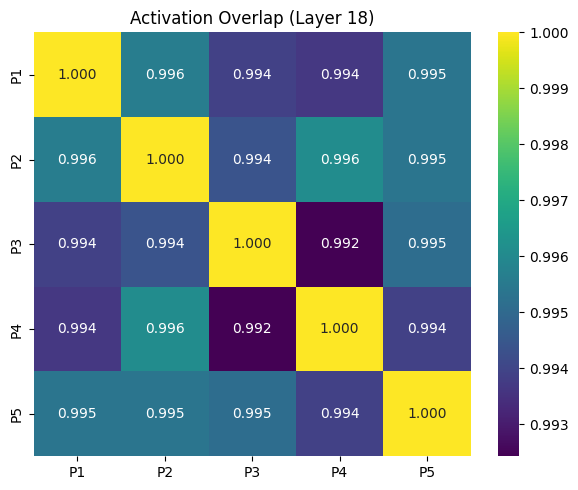

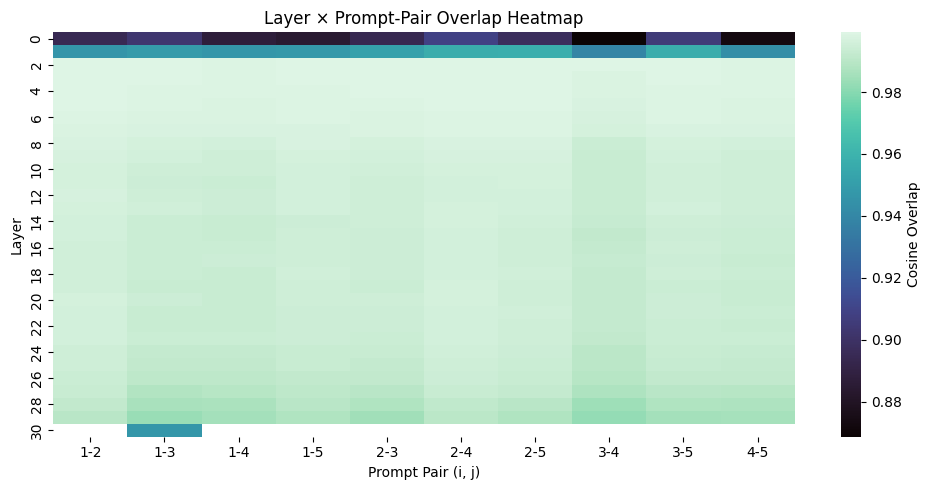

[INFO] Activation Overlap Analysis complete.


In [4]:
# =====================================================================
# ACTIVATION OVERLAP ANALYSIS — FULL ONE-CELL VERSION (ROBUST DIRECTORY DETECTION)
# Compatible with activation_probe_detailed.py output
# =====================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.spatial.distance import cosine

# ------------------------------------------------------------
# 1. Auto-detect activations directory
# ------------------------------------------------------------
candidates = [
    "activations_before",
    "activations_after",
    "activations"              # <-- created by activation_probe_detailed.py
]

base_dir = None
for c in candidates:
    if os.path.exists(c) and os.path.isdir(c):
        base_dir = c
        break

if base_dir is None:
    raise FileNotFoundError(
        "No activation directories found. Expected one of:\n"
        "  activations_before/\n"
        "  activations_after/\n"
        "  activations/\n"
        "Make sure activation_probe_detailed.py was run."
    )

print(f"[INFO] Using activation directory: {base_dir}")

# ------------------------------------------------------------
# 2. Reconstruct prompts and layers
# ------------------------------------------------------------
prompts = sorted([
    int(d.replace("prompt", ""))
    for d in os.listdir(base_dir)
    if d.startswith("prompt") and os.path.isdir(os.path.join(base_dir, d))
])

if not prompts:
    raise RuntimeError(f"No promptNN folders found inside {base_dir}/")

sample_prompt_dir = os.path.join(base_dir, f"prompt{prompts[0]:02d}")
layers = sorted([
    int(f.split("_")[0].replace("layer", ""))
    for f in os.listdir(sample_prompt_dir)
    if f.endswith("_pooled.npy")
])

if not layers:
    raise RuntimeError(f"No *_pooled.npy files found in {sample_prompt_dir}")

# ------------------------------------------------------------
# 3. Load all pooled activations
# ------------------------------------------------------------
activations = {}
for p in prompts:
    p_dir = os.path.join(base_dir, f"prompt{p:02d}")
    activations[p] = {}
    for lid in layers:
        fpath = os.path.join(p_dir, f"layer{lid:02d}_pooled.npy")
        activations[p][lid] = np.load(fpath)

print(f"[INFO] Loaded {len(prompts)} prompts × {len(layers)} layers.")
print("[INFO] Example vector shape:", activations[prompts[0]][layers[0]].shape)

# =====================================================================
# 4. OG CODE — Pairwise cosine overlap
# =====================================================================
pair_records = []
for lid in layers:
    for (p1, p2) in combinations(prompts, 2):
        v1, v2 = activations[p1][lid], activations[p2][lid]
        v1 = v1 / np.linalg.norm(v1)
        v2 = v2 / np.linalg.norm(v2)
        sim = 1 - cosine(v1, v2)
        pair_records.append({
            "Layer": lid,
            "Prompt_i": p1,
            "Prompt_j": p2,
            "Cosine_Overlap": sim
        })

df_overlap = pd.DataFrame(pair_records)
df_overlap.to_csv(os.path.join(base_dir, "activation_overlap_summary.csv"), index=False)

print(df_overlap.head())

# =====================================================================
# 5. Visualization A — Mean overlap per layer
# =====================================================================
layer_means = df_overlap.groupby("Layer")["Cosine_Overlap"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(layer_means["Layer"], layer_means["Cosine_Overlap"], marker="o")
plt.title("Average Activation Overlap per Layer")
plt.xlabel("Layer Index")
plt.ylabel("Mean Cosine Overlap")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =====================================================================
# 6. Visualization B — Mid-layer heatmap
# =====================================================================
mid_layer = layers[len(layers)//2]
df_mid = df_overlap[df_overlap["Layer"] == mid_layer]

id_to_idx = {pid: i for i, pid in enumerate(prompts)}
matrix = np.zeros((len(prompts), len(prompts)))

for _, row in df_mid.iterrows():
    i = id_to_idx[row["Prompt_i"]]
    j = id_to_idx[row["Prompt_j"]]
    matrix[i, j] = matrix[j, i] = row["Cosine_Overlap"]

np.fill_diagonal(matrix, 1.0)

plt.figure(figsize=(6,5))
sns.heatmap(matrix, annot=True, fmt=".3f", cmap="viridis",
            xticklabels=[f"P{p}" for p in prompts],
            yticklabels=[f"P{p}" for p in prompts])
plt.title(f"Activation Overlap (Layer {mid_layer})")
plt.tight_layout()
plt.show()

# =====================================================================
# 7. Visualization C — Layer × Prompt-Pair matrix
# =====================================================================
pivot = df_overlap.pivot_table(
    index="Layer",
    columns=["Prompt_i","Prompt_j"],
    values="Cosine_Overlap"
)

plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap="mako", cbar_kws={"label": "Cosine Overlap"})
plt.title("Layer × Prompt-Pair Overlap Heatmap")
plt.xlabel("Prompt Pair (i, j)")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

print("[INFO] Activation Overlap Analysis complete.")
